In [4]:
import sys
import os
sys.path.append("..")
from geomatry.opt_Energy_approximated.optimizer import MultipleSystemOptimizer
from geomatry.opt.loss import rmsd_loss
from geomatry.ff.graph import get_given_graph_builder
from geomatry.ff.springs import SpringFF, _random_spring_systems, _random_spring_ff_param
import torch
import copy

def onlyRsquare(k_perturbed, r0_perturbed, optimizer):
    ff.reset_parameters(k_perturbed, r0_perturbed)
    params_0 = ff.state_dict()
    print("params_optimized",optimizer.optimize(params_0))
    print("params_answer",k, r0)
    return copy.deepcopy(params_0)

import copy

systemN = 40
N = 20
N_pairs = 50
max_Za = 5
Ras, Zas, idx_is, idx_js = _random_spring_systems(systemN, N, N_pairs, max_Za, start_Za=1)
k, r0 = _random_spring_ff_param(max_Za, r0_max=10, k_max=10)
ff = SpringFF(max_Za)
ff.reset_parameters(k, r0)

fixed_atom_indices = [0,1,2]
graph_builders = [get_given_graph_builder(idx_i, idx_j) for idx_i, idx_j in zip(idx_is, idx_js)]

# start implicit optimization
import copy
params_star = copy.deepcopy(ff.state_dict())
#params_star = copy.deepcopy(ff.state_dict())
#print("params_star", params_star)
optimizer = MultipleSystemOptimizer(
    Ras, Zas, graph_builders, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)
k_perturbed = -k.clone() + 3 * torch.randn_like(k)
r0_perturbed = torch.abs(r0.clone() + 3 * torch.randn_like(r0))

#k_perturbed = -k.clone()
#r0_perturbed = torch.clamp(r0.clone() + 0.1 * torch.randn_like(r0), min=0)

ff.reset_parameters(k_perturbed, r0_perturbed)
params_0 = copy.deepcopy(ff.state_dict())

print('start', params_0)
print('goal',params_star)

start OrderedDict([('k', tensor([[ -1.7956, -10.5309,  -1.9155,  -6.6895,   1.0687,  -5.6320],
        [-10.5309,  -2.6806,  -9.0334,  -7.0018,  -8.2725,  -8.0462],
        [ -1.9155,  -9.0334,  -8.5828,  -3.8149,  -3.2624,  -6.9144],
        [ -6.6895,  -7.0018,  -3.8149,  -7.4700,  -8.7992, -10.5585],
        [  1.0687,  -8.2725,  -3.2624,  -8.7992,  -5.9470,  -7.7839],
        [ -5.6320,  -8.0462,  -6.9144, -10.5585,  -7.7839, -10.6256]],
       dtype=torch.float64)), ('r0', tensor([[ 1.2330,  2.3584,  5.6952,  2.8111,  3.1078,  1.8715],
        [ 2.3584,  7.0612,  6.5542,  2.7691,  9.7969,  5.9702],
        [ 5.6952,  6.5542,  0.2211,  0.4369, 12.0861,  5.9487],
        [ 2.8111,  2.7691,  0.4369,  8.5186,  6.3863,  2.9962],
        [ 3.1078,  9.7969, 12.0861,  6.3863,  6.5004,  6.1465],
        [ 1.8715,  5.9702,  5.9487,  2.9962,  6.1465,  5.9676]],
       dtype=torch.float64))])
goal OrderedDict([('k', tensor([[0.2031, 8.9166, 1.6668, 5.3208, 3.0745, 5.3800],
        [8.9166, 2.

Ra_star_energy tensor(-1118.5422, dtype=torch.float64, grad_fn=<DivBackward0>)


/var/folders/d9/j9pnzj2s30jf7r3wxfwp0yz80000gn/T/ipykernel_16600/1966093366.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Ra_temp[:,:]+=x[i]*n1
/var/folders/d9/j9pnzj2s30jf7r3wxfwp0yz80000gn/T/ipykernel_16600/1966093366.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Ra_temp[:,:]-=x[i]*n1


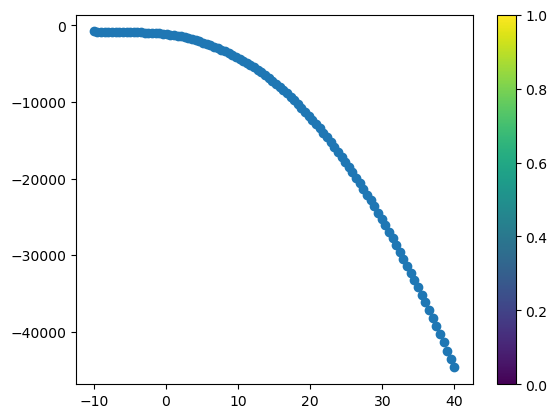

In [5]:
#Draw energy landscape near real optimal geometry
#In direction towards current local minimum
from torch import FloatTensor, IntTensor
from ase import Atoms
import numpy as np
import matplotlib.pyplot as plt

def get_ase_atoms(Ra: FloatTensor, Za: IntTensor) -> Atoms:
    return Atoms(
        positions=Ra.detach().cpu().numpy(),
        numbers=Za.detach().cpu().numpy()
    )

def getMaxDirection(optimizer, params_0, index):
    Ra_star_0=optimizer.fitting._get_Ra_star(params_0,optimizer.graph_builders[index],optimizer.Ra_stars[index],optimizer.Zas[index],optimizer.fixed_atom_indices)
    direction=(Ra_star_0-optimizer.Ra_stars[index]).detach().numpy()
    return direction/np.linalg.norm(direction)

def drawGraphs(optimizer,params, index):
    n1=getMaxDirection(optimizer,params, index)
    if (np.isnan(n1[0,0])):
        n1=np.zeros(n1.shape)
        n1[0,0]=1
    optimizer.ff.reset_parameters(params['k'],params['r0'])
    Ra_temp=copy.deepcopy(optimizer.Ra_stars[index])
    atoms=get_ase_atoms(Ra_temp, optimizer.Zas[index])
    x=np.linspace(-10,40,100)
    z1=copy.deepcopy(x)
    for i in range(100):
        Ra_temp[:,:]+=x[i]*n1
        E0=optimizer.ff.get_E(Ra_temp,optimizer.Zas[index],*optimizer.graph_builders[index](atoms))
        z1[i]=E0
        Ra_temp[:,:]-=x[i]*n1
    #z1[z1>30]=30
    print('Ra_star_energy',optimizer.ff.get_E(Ra_temp,optimizer.Zas[index],*optimizer.graph_builders[index](atoms)))
    plt.scatter(x,z1)
    plt.colorbar()
param={'k':k_perturbed, 'r0':r0_perturbed}
drawGraphs(optimizer,params_0,0)

params_0 OrderedDict([('k', tensor([[ -1.7956, -10.5309,  -1.9155,  -6.6895,   1.0687,  -5.6320],
        [-10.5309,  -2.6806,  -9.0334,  -7.0018,  -8.2725,  -8.0462],
        [ -1.9155,  -9.0334,  -8.5828,  -3.8149,  -3.2624,  -6.9144],
        [ -6.6895,  -7.0018,  -3.8149,  -7.4700,  -8.7992, -10.5585],
        [  1.0687,  -8.2725,  -3.2624,  -8.7992,  -5.9470,  -7.7839],
        [ -5.6320,  -8.0462,  -6.9144, -10.5585,  -7.7839, -10.6256]],
       dtype=torch.float64)), ('r0', tensor([[ 1.2330,  2.3584,  5.6952,  2.8111,  3.1078,  1.8715],
        [ 2.3584,  7.0612,  6.5542,  2.7691,  9.7969,  5.9702],
        [ 5.6952,  6.5542,  0.2211,  0.4369, 12.0861,  5.9487],
        [ 2.8111,  2.7691,  0.4369,  8.5186,  6.3863,  2.9962],
        [ 3.1078,  9.7969, 12.0861,  6.3863,  6.5004,  6.1465],
        [ 1.8715,  5.9702,  5.9487,  2.9962,  6.1465,  5.9676]],
       dtype=torch.float64))])


  0%|          | 0/60001 [00:00<?, ?it/s]

0 curvature -15.86655133267117 43371.807306436735 distance -13.124651636410197 loss 150879.38581427233
trueloss 150879.38581427233
loss 150868.2822437342
tensor([-100.8316, -123.2986,  -88.7470,  -98.8048,  -65.5986, -101.5124],
       dtype=torch.float64, grad_fn=<SubBackward0>)


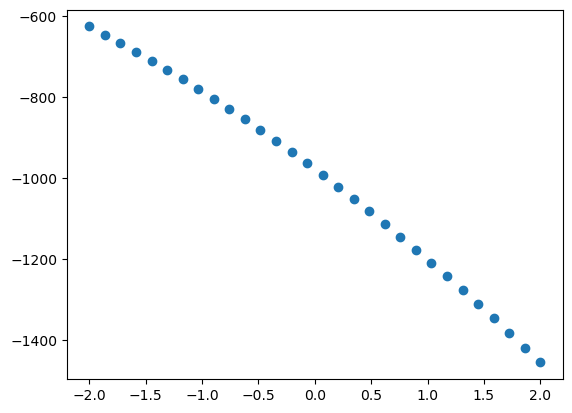

 33%|███▎      | 19988/60001 [01:57<03:44, 178.44it/s]

20000 curvature -5.944553264779418 0.9132626714376565 distance -0.00932418973972601 loss 22.107728202909776
trueloss 22.107728202909776
loss 10.509401072349805
tensor([-1.2489, -0.6093, -0.8742, -0.6503, -0.7115, -0.7058],
       dtype=torch.float64, grad_fn=<SubBackward0>)


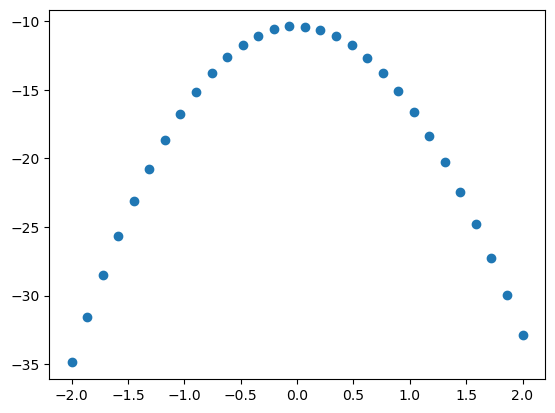

 67%|██████▋   | 39994/60001 [04:03<02:08, 155.45it/s]

40000 curvature 0.1419148906197676 0.48008548622565195 distance 0.0518049839774537 loss 2.0841649820546184
trueloss 2.0841649820546184
loss 2.0839908466903783
tensor([0.0272, 0.0246, 0.0364, 0.0112, 0.0172, 0.0397], dtype=torch.float64,
       grad_fn=<SubBackward0>)


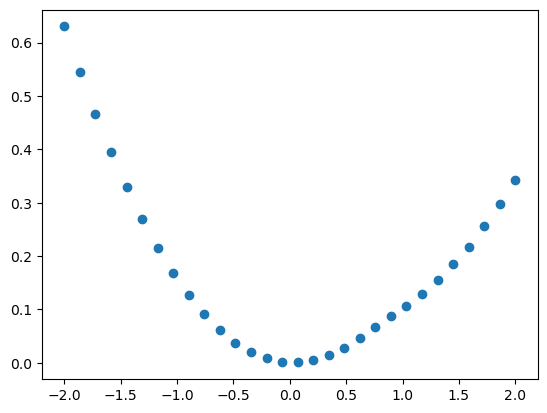

100%|█████████▉| 59987/60001 [06:04<00:00, 125.35it/s]

60000 curvature 7.437197852826884 1.7159352914724218e-05 distance 0.001263050435841447 loss 0.02007296773013361
trueloss 0.02007296773013361
loss 0.02007296773013361
tensor([0.9910, 1.8052, 0.6766, 1.1678, 1.8780, 1.1549], dtype=torch.float64,
       grad_fn=<SubBackward0>)


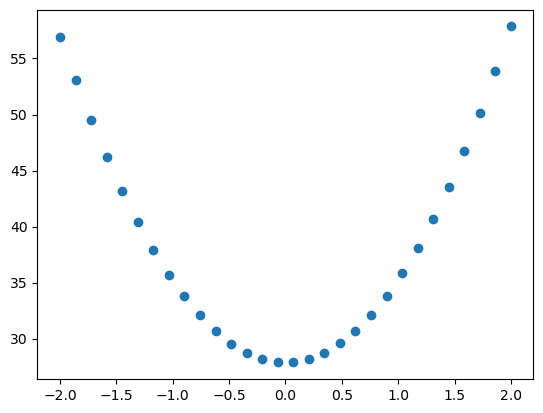

100%|██████████| 60001/60001 [06:04<00:00, 164.52it/s]


In [6]:
def energyAndRsquare(k_perturbed, r0_perturbed, optimizer):
    ff.reset_parameters(k_perturbed, r0_perturbed)
    params_0 = ff.state_dict()
    print("params_0", params_0)
    for i in range(1):
        params_0=optimizer.optimize(params_0, 60001, 20000, 0.1, 6, 2)
    return params_0
new_params_0=energyAndRsquare(k_perturbed, r0_perturbed, optimizer)


/var/folders/d9/j9pnzj2s30jf7r3wxfwp0yz80000gn/T/ipykernel_16600/942741433.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Ra_temp[:,:]+=x[i]*n1
/var/folders/d9/j9pnzj2s30jf7r3wxfwp0yz80000gn/T/ipykernel_16600/942741433.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Ra_temp[:,:]-=x[i]*n1


Ra_star_energy tensor(8.5324, dtype=torch.float64, grad_fn=<DivBackward0>)


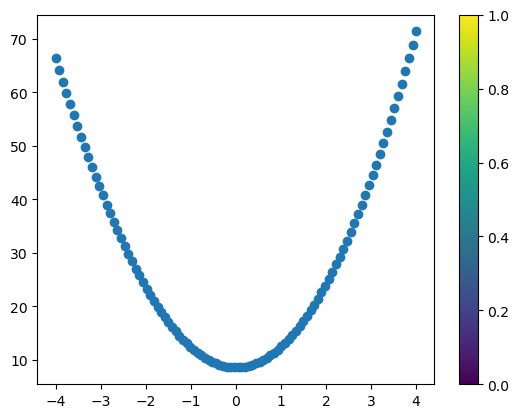

In [7]:
#Draw energy landscape near real optimal geometry
#In direction towards current local minimum
from torch import FloatTensor, IntTensor
from ase import Atoms
import numpy as np
import matplotlib.pyplot as plt

def get_ase_atoms(Ra: FloatTensor, Za: IntTensor) -> Atoms:
    return Atoms(
        positions=Ra.detach().cpu().numpy(),
        numbers=Za.detach().cpu().numpy()
    )

def getMaxDirection(optimizer, params_0, index):
    Ra_star_0=optimizer.fitting._get_Ra_star(params_0,optimizer.graph_builders[index],optimizer.Ra_stars[index],optimizer.Zas[index],optimizer.fixed_atom_indices)
    direction=(Ra_star_0-optimizer.Ra_stars[index]).detach().numpy()
    return direction/np.linalg.norm(direction)

def drawGraphs(optimizer,params, index):
    n1=getMaxDirection(optimizer,params, index)
    if (np.isnan(n1[0,0])):
        n1=np.zeros(n1.shape)
        n1[-1,0]=1
    optimizer.ff.reset_parameters(params['k'],params['r0'])
    Ra_temp=copy.deepcopy(optimizer.Ra_stars[index])
    atoms=get_ase_atoms(Ra_temp, optimizer.Zas[index])
    x=np.linspace(-4,4,100)
    z1=copy.deepcopy(x)
    for i in range(100):
        Ra_temp[:,:]+=x[i]*n1
        E0=optimizer.ff.get_E(Ra_temp,optimizer.Zas[index],*optimizer.graph_builders[index](atoms))
        z1[i]=E0
        Ra_temp[:,:]-=x[i]*n1
    #z1[z1>30]=30
    print('Ra_star_energy', optimizer.ff.get_E(Ra_temp,optimizer.Zas[index],*optimizer.graph_builders[index](atoms)))
    plt.scatter(x,z1)
    plt.colorbar()
param={'k':k_perturbed, 'r0':r0_perturbed}
drawGraphs(optimizer,new_params_0,0)

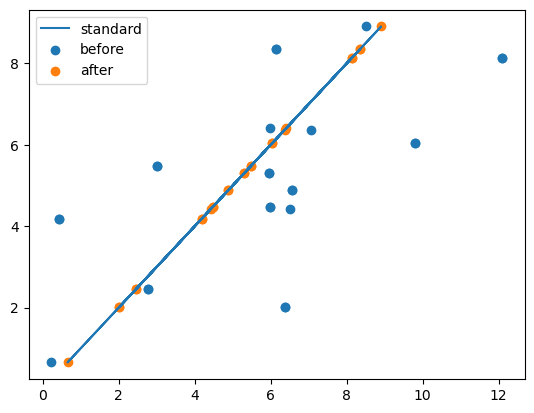

In [8]:
#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_0['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(new_params_0['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

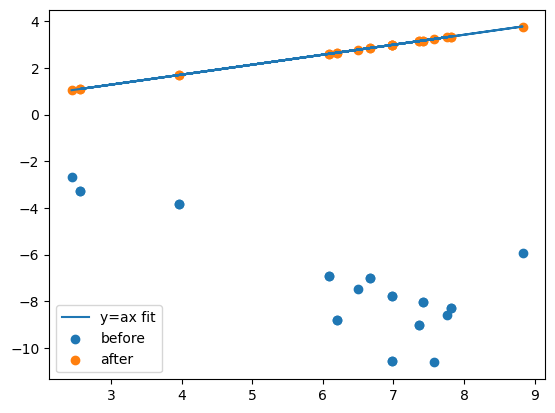

In [9]:
#Compare
import matplotlib.pyplot as plt

new_params_0['k']=(new_params_0['k']+new_params_0['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0['k']=(params_0['k']+params_0['k'].T)/2

a=torch.sum(new_params_0['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()